In [1]:
import os
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
import numpy as np


from ipywidgets import Layout, interact, IntSlider, FloatSlider
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

import DL_Sequence
import iSCAT_Datasets

# num_classes = 5
# res = 64
# exPT_cnt = 100
# devPT_cnt = 99
# exIntensity=1.0
# devIntensity=0.3
# frames = 32

# mode = "dynamic"
# PSF_path="../PSF_subpx_fl32.npy"
# PSF = np.load(PSF_path)

# dataset = DL_Sequence.iSCAT_DataGenerator(batch_size=32, epoch_size=128, res=res, frames=frames, thread_count=40,
#                     PSF_path=PSF_path, exD=5000, devD=4000, exPT_cnt=exPT_cnt, devPT_cnt=devPT_cnt, exIntensity=exIntensity, devIntensity=devIntensity, target_frame=15,
#                     num_classes=num_classes, verbose = 2, noise_func = None, mode = mode)

# data = dataset.samples
# targets = dataset.particles_in_sight_cnt
# target_masks = dataset.target_masks
# poss = dataset.particle_positions
# pt_cnts = dataset.pt_cnts
# dataset.destroy()


epoch_size = 128
batch_size = 32
num_classes, frames, res, dataset = iSCAT_Datasets.getDatasetGen(0, epoch_size, batch_size, verbose=2, regen=False)

data = dataset.samples
targets = dataset.particles_in_sight_cnt
target_masks = dataset.target_masks
poss = dataset.particle_positions
pt_cnts = dataset.pt_cnts
dataset.destroy()

Sample width:  448
particlesWorker: Run
Particle generation time: 0.071s
sampleWorker:particlesWorker:  RunRun

Sparse Subpixel Convolution initialized
Preparation of memory took 6 ms
Preparation of memory took 0 ms
Particle generation time: 0.102s

OMP max threads: 24
OMP setting number of threads to 16
Computation of convolutions took 186 ms
Conv generation time: 0.251s
Target generation time: 0.001s
Whole generation time: 0.317s

OMP max threads: 16
OMP setting number of threads to 16
Computation of convolutions took 19 ms
sampleWorker:particlesWorker:Min particle in sight cnt: 0
Max particle in sight cnt: 7
Avg particle in sight cnt: 3.4140625
Std particle in sight cnt: 2.0861423120424334
class: 0     |1     |2     |3     |4     |5     |6     |7     |
count: 8     |22    |19    |20    |15    |19    |13    |12    |
  DieDie



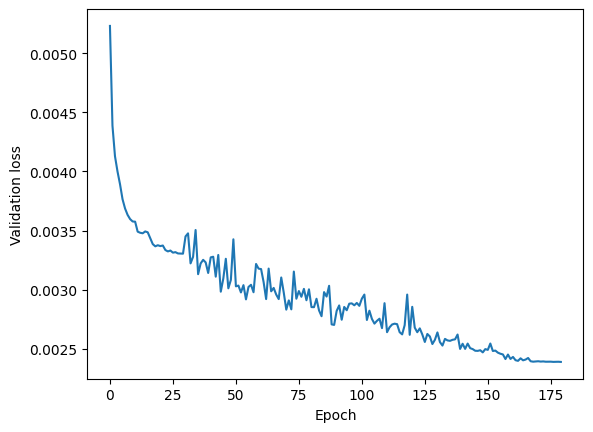

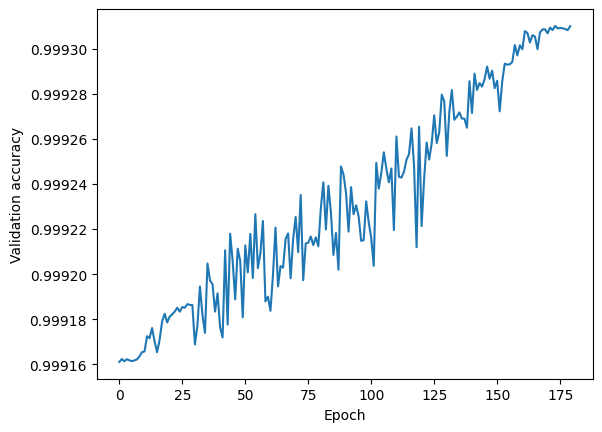

In [3]:
progress_filename = "models/resnet_unet_progress.txt"

#Plot training progress
f = open(progress_filename, "r")
lines = f.read().split("\n")
f.close()

loss_vals = []
accuracy_vals = []
for line in lines[:-1]:
    vals = line.split(" ; ")
    loss_vals.append(float(vals[0]))
    accuracy_vals.append(float(vals[1]))

plt.plot(loss_vals)
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.show()
plt.plot(accuracy_vals)
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.show()
    

In [2]:
import tensorflow as tf

print(tf.keras.backend.image_data_format())
tf.keras.backend.set_image_data_format('channels_first')
print(tf.keras.backend.image_data_format())
    

class ResNet(tf.keras.Model):    
    def _cnn(self, inputs, filters, kernel_size, stride, activation):
        hidden = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same", use_bias=False)(inputs)
        hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = tf.keras.layers.Activation(tf.nn.swish)(hidden) if activation else hidden
        return hidden

    def _block(self, inputs, filters, stride, layer_index):
        hidden = self._cnn(inputs, filters, self.kernel_size, stride, activation=True)
        hidden = self._cnn(hidden, filters, self.kernel_size, 1, activation=False)
           
        residual = self._cnn(inputs, filters, 1, stride, activation=False) if stride > 1 else inputs
        
        hidden = residual + hidden
        hidden = tf.keras.layers.Activation(tf.nn.swish)(hidden)
        return hidden

    def __init__(self, shape, num_classes, depth, filters_start, kernel_size):
        self.shape = shape
        self.num_classes = num_classes
        self.depth = depth

        self.filters_start = filters_start
        self.kernel_size = kernel_size

        n = (depth - 2) // 6

        inputs = tf.keras.Input(shape=shape, dtype=tf.float32)
        hidden = self._cnn(inputs, filters_start, kernel_size, 1, activation=True)
        for stage in range(3):
            for block in range(n):
                hidden = self._block(hidden, filters_start * (1 << stage), 2 if stage > 0 and block == 0 else 1, (stage * n + block) / (3 * n - 1))
        hidden = tf.keras.layers.GlobalAvgPool2D()(hidden)
        outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)(hidden)

        super().__init__(inputs, outputs)



def create_and_load_model():
    dataset = 0
    
    depth = 62
    kernel_size = 3

    backbone_comment = "_dataset-" + str(dataset)
    backbone_name = "backbones/model_resnet_k" + str(kernel_size) + backbone_comment

    backbone = ResNet((frames, res, res), num_classes, depth, frames, kernel_size)
    backbone.load_weights(backbone_name + "_weights/")
    backbone.trainable = False
    
    backbone.summary()

    # (128, 16, 16), (64, 32, 32), (32, 64, 64)
    backbone = tf.keras.Model(
        inputs=backbone.input,
        outputs=[backbone.get_layer(layer).output for layer in [
                "activation_60", "activation_40", "activation_20"]]
    )

    def cnn_layer(inputs, filters, kernel_size, stride, activation):
        hidden = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same", use_bias=False)(inputs)
        hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = tf.keras.layers.Activation(tf.nn.swish)(hidden) if activation else hidden
        return hidden

    filters = [128, 64, 32]
    hidden = backbone.outputs[0]
    cnn_blocks = 30
    for ii in range(len(backbone.outputs) - 1):
        conv = backbone.outputs[ii + 1]
        channels = filters[ii + 1]

        conv = tf.keras.layers.Conv2D(channels, kernel_size=1)(conv)
        hidden = tf.keras.layers.Conv2DTranspose(channels, kernel_size=2, strides=2, padding="same")(hidden)
        hidden = tf.keras.layers.Concatenate(axis=1)([hidden, conv])
        hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = tf.keras.layers.Activation(tf.nn.swish)(hidden)

        hidden = cnn_layer(hidden, channels, 3, 1, True)
        for i in range(cnn_blocks):
            residual = hidden
            hidden = cnn_layer(hidden, channels, 3, 1, True)
            hidden = cnn_layer(hidden, channels, 3, 1, False)
            hidden += residual
            hidden = tf.keras.layers.Activation(tf.nn.swish)(hidden)

    outputs = tf.keras.layers.Conv2D(1, kernel_size=3, padding="same", activation=tf.nn.sigmoid)(hidden)

    model = tf.keras.Model(inputs=backbone.inputs, outputs=outputs)
    
    model_name = "models/resnet_unet"
    model.load_weights(model_name + "_weights/")
    
    return model

channels_last
channels_first


In [3]:


test_model = True
if test_model:
    model = create_and_load_model()
    predictions = model.predict(data)
    predictions = np.array(predictions)
    print(predictions.shape)


print(data.shape, targets.shape)

print(np.max(data), np.min(data))
print(np.mean(targets), np.std(targets))


Model: "res_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 64, 64)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 64, 64)   9216        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

 batch_normalization_9 (BatchNo  (None, 32, 64, 64)  256         ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 32, 64, 64)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 64, 64)   9216        ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 64, 64)  256         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf.__oper

 conv2d_19 (Conv2D)             (None, 32, 64, 64)   9216        ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 32, 64, 64)  256         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 32, 64, 64)   0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 64, 64)   9216        ['activation_19[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 32, 64, 64)  256         ['conv2d_20[0][0]']              
 ormalizat

 ormalization)                                                                                    
                                                                                                  
 tf.__operators__.add_13 (TFOpL  (None, 64, 32, 32)  0           ['activation_26[0][0]',          
 ambda)                                                           'batch_normalization_29[0][0]'] 
                                                                                                  
 activation_28 (Activation)     (None, 64, 32, 32)   0           ['tf.__operators__.add_13[0][0]']
                                                                                                  
 conv2d_30 (Conv2D)             (None, 64, 32, 32)   36864       ['activation_28[0][0]']          
                                                                                                  
 batch_normalization_30 (BatchN  (None, 64, 32, 32)  128         ['conv2d_30[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_39 (BatchN  (None, 64, 32, 32)  128         ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf.__operators__.add_18 (TFOpL  (None, 64, 32, 32)  0           ['activation_36[0][0]',          
 ambda)                                                           'batch_normalization_39[0][0]'] 
                                                                                                  
 activation_38 (Activation)     (None, 64, 32, 32)   0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 conv2d_40 (Conv2D)             (None, 64, 32, 32)   36864       ['activation_38[0][0]']          
          

                                                                                                  
 batch_normalization_49 (BatchN  (None, 128, 16, 16)  64         ['conv2d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_47 (Activation)     (None, 128, 16, 16)  0           ['batch_normalization_49[0][0]'] 
                                                                                                  
 conv2d_50 (Conv2D)             (None, 128, 16, 16)  147456      ['activation_47[0][0]']          
                                                                                                  
 batch_normalization_50 (BatchN  (None, 128, 16, 16)  64         ['conv2d_50[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_59 (Conv2D)             (None, 128, 16, 16)  147456      ['activation_56[0][0]']          
                                                                                                  
 batch_normalization_59 (BatchN  (None, 128, 16, 16)  64         ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_57 (Activation)     (None, 128, 16, 16)  0           ['batch_normalization_59[0][0]'] 
                                                                                                  
 conv2d_60 (Conv2D)             (None, 128, 16, 16)  147456      ['activation_57[0][0]']          
                                                                                                  
 batch_nor

4/4 [==============================] - 6s 103ms/step
(128, 1, 64, 64)
(128, 32, 64, 64) (128,)
1.0 0.0
3.4140625 2.0861423120424334


In [8]:
sample_inds = np.insert(np.cumsum(pt_cnts), 0, 0)

sample_size_px = 480
FOV_edge = sample_size_px / 2 - res / 2

def plot_step_fast(step, sample_cur):    
    imgs = data[sample_cur]
    masks = target_masks[sample_cur]
    
    begin = sample_inds[sample_cur]
    end = begin + pt_cnts[sample_cur]
    
    poss_step = step % poss.shape[0]
    
    x = poss[poss_step, begin:end, 1]
    y = poss[poss_step, begin:end, 0]
    
#     plt.subplot(1, 2, 1)
#     plt.axis([-FOV_edge, sample_size_px-FOV_edge, -FOV_edge, sample_size_px-FOV_edge])
#     plt.gca().add_patch(Rectangle((0, 0), res, res, edgecolor = 'red', fill=False))
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.scatter(x,y)
    
    plt.subplot(1, 3, 1)
    plt.imshow(imgs[step, :, :])
    plt.axis([-0.5, res-0.5, -0.5, res-0.5])
    plt.scatter(x,y, c="red")
    plt.title("Data")
#     plt.show()
    
    plt.subplot(1, 3, 2)
    plt.imshow(masks[step, :, :])
    plt.axis([-0.5, res-0.5, -0.5, res-0.5])
    plt.title("Ground truth")
    
#     print("gold:", targets[sample_cur])
    
    
    if test_model:
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[sample_cur, 0, :, :])
        plt.axis([-0.5, res-0.5, -0.5, res-0.5])
        plt.title("Predicted probabilities")
    plt.show()


    
interact(plot_step_fast, step=IntSlider(min=0, max=data.shape[1] - 1, value=data.shape[1] // 2 -1), sample_cur=IntSlider(min=0, max=data.shape[0] - 1));

interactive(children=(IntSlider(value=15, description='step', max=31), IntSlider(value=0, description='sample_…

In [42]:
pred_pt_poss = []

#Get predicted particle locations
# for sample_cur in range(data.shape[0]):
for sample_cur in range(1):
    begin = sample_inds[sample_cur]
    end = begin + pt_cnts[sample_cur]
    
    x = poss[15, begin:end, 1]
    y = poss[15, begin:end, 0]
    
    xc_in_sight = (y > 0) & (y < res)
    yc_in_sight = (x > 0) & (x < res)
    pt_in_sight = xc_in_sight & yc_in_sight

    true_pts = np.array([x[pt_in_sight.nonzero()],y[pt_in_sight.nonzero()]])
    
    pt_count = targets[sample_cur]
    pred_probs = predictions[sample_cur, 0, :, :]
    
#     plt.imshow(predictions[sample_cur, 0, :, :])
#     plt.axis([-0.5, res-0.5, -0.5, res-0.5])
#     plt.title("Predicted probabilities")
#     plt.show()
    
#     pred_probs_sorted = np.unravel_index(np.argsort(pred_probs, axis=None), pred_probs.shape)
    pred_probs_sorted = np.dstack(np.unravel_index(np.argsort(pred_probs.ravel()), pred_probs.shape))[0]
    
#     print(pred_probs_sorted.shape)
    
    pred_poss = np.array([pred_probs_sorted[-pt_count:,1], pred_probs_sorted[-pt_count:,0]])
    pred_pt_poss.append(pred_poss)
    
    pred_poss_pom = np.copy(pred_poss)
    true_pts_pom = np.copy(true_pts)
    
    for ii in range(pt_count):
        for iii in range(pt_count - ii):
            true_pts_pom[0][iii] - pred_poss_pom
    
#     y_dif = pred_poss[0][:, None] - true_pts[0][None, :] + 0.5
#     x_dif = pred_poss[1][:, None] - true_pts[1][None, :] + 0.5
#     dif = np.sqrt(x_dif**2 + y_dif**2)
    
#     print(pred_poss[0][:, None], true_pts[0][None, :])
    print(dif)
    print(np.min(dif, axis = 1))
    
#     print(pred_particle_positions, true_pts)
    
# print(pred_pt_poss.shape)
    

[[50.99184892  1.57440282 52.23672722 54.85960328]
 [ 2.09433514 50.2384715  18.79554674 13.22186902]
 [50.31975252  2.12078086 51.32517729 54.00752147]
 [19.785678   53.06471065  1.73518255  5.60250841]]
[1.57440282 2.09433514 2.12078086 1.73518255]


In [37]:
sample_inds = np.insert(np.cumsum(pt_cnts), 0, 0)

sample_size_px = 480
FOV_edge = sample_size_px / 2 - res / 2



def plot_step_fast(step, sample_cur):    
    imgs = data[sample_cur]
    masks = target_masks[sample_cur]
    
    begin = sample_inds[sample_cur]
    end = begin + pt_cnts[sample_cur]
    
    poss_step = step % poss.shape[0]
    
    x = poss[poss_step, begin:end, 1]
    y = poss[poss_step, begin:end, 0]
    
    pred_poss = pred_pt_poss[sample_cur]
    
    plt.subplot(1, 3, 1)
    plt.imshow(imgs[step, :, :])
    plt.axis([-0.5, res-0.5, -0.5, res-0.5])
    plt.scatter(x,y, c="red")
    plt.scatter(pred_poss[0],pred_poss[1], c="blue")
    plt.title("Data")
#     plt.show()
    
    plt.subplot(1, 3, 2)
    plt.imshow(masks[step, :, :])
    plt.axis([-0.5, res-0.5, -0.5, res-0.5])
    plt.title("Ground truth")
    
    print("gold:", targets[sample_cur])
    
    
    if test_model:
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[sample_cur, 0, :, :])
        plt.axis([-0.5, res-0.5, -0.5, res-0.5])
        plt.title("Predicted probabilities")
    plt.show()


    
interact(plot_step_fast, step=IntSlider(min=0, max=data.shape[1] - 1, value=data.shape[1] // 2 -1), sample_cur=IntSlider(min=0, max=data.shape[0] - 1));

interactive(children=(IntSlider(value=15, description='step', max=31), IntSlider(value=0, description='sample_…